# ANÁLISIS UNIVARIADO DE SERIES DE TIEMPO (BITCOIN) USANDO REDES RNN-LSTM A UN PASO
#### Análisis unidimensional (univariado) y a un paso de la serie de tiempo del precio de Bitcoin.

<a name="contents"></a>
# Contenido

- [Notas, desconexión y librerías](#conecct)
- [Importando y visualizando datos (información) del bitcoin (y librería opcional en caso de que la usada deje de funcionar)](#data)
- [Función de preparación de datos (univariate_data)](#univariate_data)
- [Selección y visualización de datos a tratar](#select&PlottingData)
- [Definiendo hiperparámetros y estandarizando los datos](#hyper&Standard)
- [Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow](#Distr&TFFormat)
- [Funciones para graficar predicción y pérdida](#plotFuncts)
- [Función(es) de creación del modelo RNN-LSTM](#modelFunct)
- [PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.](#1stModels)
- [Primeras gráficas: Graficando predicciones (de 8, 128 y 256 neuronas) y mostrando errores (MSE)](#1stPredPlots)
- [SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 128 y 512 neuronas)](#sameModels)
- [Caracterizando el error (MSE) con modelos de 256 neuronas](#Errors)
- [Conclusiones e ideas](#Conclu)

<a name="conecct"></a>
# Notas, desconexión y librerías:
- La primera celda es un código que en teoría evita la desconexión de Colab.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Source: https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#0d57
#Stop Colab from disconecting:
#ctl+shift+i -> console -> command lines:
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

In [ ]:
#To import data
#!pip install pandas_datareader #For COLAB #Use if yfinance does not work #import pandas_datareader.data as web
#installing yfinance (Colab)
!pip install yfinance
#pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
#For Bootstrap
!pip install dc_stat_think
import dc_stat_think as dcst
#To use goodness fit test
from scipy import stats
import random
#Data managing
import numpy as np
import os
import pandas as pd
#To comparison forecasts
from sklearn.metrics import mean_squared_error
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#Importing images
from google.colab import files
from io import BytesIO
from PIL import Image
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

#I dont know for what are these packages
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 6.3MB 11.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=b29a07c7a6b7a095390846eb0712d356800b33ee061f2387b5188ff29bd65e1a
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


<a name="data"></a>
# Importando y visualizando datos (información) del Bitcoin:
## Registros diarios (uno por día)
Como se puede ver hay se tienen 2481 registros diarios del Bitcoin desde el 2014 hasta la fecha:

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Univariate time series
#df_btc= web.DataReader("BTC-USD", 'yahoo')#Use if yfinance does not work
print("-------------------------------- DATA -------------------------------")
df_btc = pdr.get_data_yahoo(["BTC-USD"])

print(type(df_btc))
print("---------------------------Head & Tail----------------------------")
print(df_btc.head(2))
print(df_btc.tail(2))
print("---------------------------Description----------------------------")
#NOTE: Check that index is date by default
print(type(df_btc.index))
print(df_btc.describe())
#df_btc.sort_index(ascending=False).head()

-------------------------------- DATA -------------------------------
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
---------------------------Head & Tail----------------------------
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200

[2 rows x 6 columns]
                    Open          High  ...     Adj Close       Volume
Date                                    ...                           
2021-07-17  31397.308594  31935.945312  ...  31533.068359  18895018942
2021-07-19  31742.322266  31830.460938  ...  31578.572266  18100234240

[2 rows x 6 columns]
---------------------------Description----------------------------
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
               Open          High  ...     Adj Close       

## (Opcional) Otra librería (no usada) para importar datos:
La siguiente celda se puede omitir pues solo muestra la aplicación de unos métodos para series de tiempo univariadas (usando Ticker) y como importar series de tiempo multivariadas:

In [ ]:
###NOTE: minimum interval: 1 minute
#------------------------
#Univariate time series
#------------------------
df_btc_T = yf.Ticker("BTC-USD")
#type(df_btc)
#Exploring some methods
#df_btc.info
#df_btc.actions
#df_btc.financials
#df_btc.history(period="max")
#df_btc.calendar
#### valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#df_btc.history(period="2d",interval="1m") 

#-------------------------
#Multivariate time series
#-------------------------

#Several time series
starDate="2017-01-01" #year-month-day
endDate="2017-04-30"
data = web.DataReader("BTC-USD ETH-USD", start=starDate, end=endDate)
print(data)
#print(data["Adj Close"])
#print(type(data["Adj Close"]["BTC-USD"]))
#print(data["Adj Close"]["BTC-USD"])
#dataTickers = yf.Tickers('BTC-USD ETH-USD')
#print(dataTickers.tickers["BTC-USD"].info)
#print(dataTickers.tickers["ETH-USD"].history(period="1mo"))

[*********************100%***********************]  2 of 2 completed


<a name="univariate_data"></a>
# Función de preparación de datos (univariate_data):
- Para análisis univariado, datos ya estandarizados o normalizados.
- *Idea:* Candidata a exportar.

Volver a [Tabla de contenidos](#contents).

Saving univ_data.jpg to univ_data.jpg


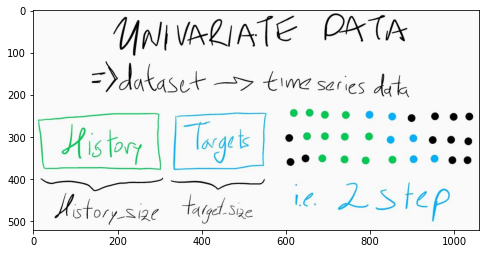

In [ ]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded["univ_data.jpg"]))
plt.imshow(im)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  ''' 
      dataset: Array containing the whole time series (stadarized or not)
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: size of data to predict
  '''
  hist = [] #hist = history
  targets = [] 

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    #window = window of time
    window = range(i-history_size,i) #it balances the start_index = start_index + history_size made above
    #print(window,i)
    #print(window)
    #Reshape hist from (history_size,) to (history_size,1)
    hist.append(np.reshape(dataset[window], (history_size, 1))) #len(dataset[window]) = history_size
    #print(hist)
    targets.append(dataset[i+target_size-1])#note: the "-1" is not in the original code"
  return np.array(hist), np.array(targets)

Mirando como trabaja la función univariate_data haciendo una prueba:

In [ ]:
test = np.arange(0,10)
#print(type(test))
#print(test)
#print(test[range(0,4)]) #equivalent to dataset[window]
#print(np.reshape(test[range(0,4)], (4,1)))
#print(test.shape[])
#x,y = univariate_data(dataset=test, start_index=0, end_index=8, history_size=4,target_size=1)
#print(x)
#print(y)
#a = range(-5,5)

<a name="select&PlottingData"></a>
#Selección y visualización de datos a tratar.
### Seleccionando los datos de la serie de tiempo a analizar
- Seleccionando los datos de cierre.
- Gráfica de los datos de entrenamiento y validación.
- Extrayendo los valores del dataframe (se deja de trabajar con un dataframe, y se pasa a trabajar con un array).

Volver a [Tabla de contenidos](#contents).

Date
2021-07-16    31421.539062
2021-07-17    31533.068359
2021-07-19    31578.572266
Name: Adj Close, dtype: float64


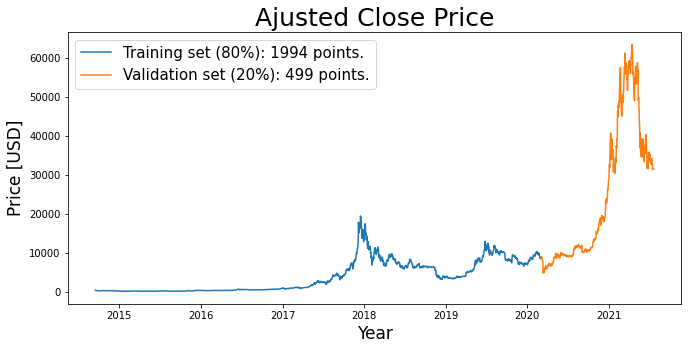

<class 'numpy.ndarray'>


In [ ]:
#Extrating data from data frame:
uni_data = df_btc['Adj Close']
print(uni_data.tail(3))

#Hiperparameter
TRAIN_SPLIT = int(len(df_btc)*0.8)

#Plotting
plt.figure(figsize=(11,5))
plt.plot(uni_data[:TRAIN_SPLIT], label="Training set (80%): "+str(TRAIN_SPLIT)+" points.")
plt.plot(uni_data[TRAIN_SPLIT:], label="Validation set (20%): "+str(len(df_btc)-TRAIN_SPLIT)+" points.")
#plt.plot(uni_data[:TRAIN_SPLIT], label="Conjunto de entrenamiento (80%): "+str(TRAIN_SPLIT)+" datos.")
#plt.plot(uni_data[TRAIN_SPLIT:], label="Conjunto de validación (20%): "+str(len(df_btc)-TRAIN_SPLIT)+" datos.")
plt.title("Ajusted Close Price", size=25)
#plt.title("Precio de cierre ajustado", size=25)
plt.xlabel("Year", size=17)
#plt.xlabel("Año", size=16)
plt.ylabel("Price [USD]", size=17)
#plt.ylabel("Precio [USD]", size=16)
plt.legend(fontsize = 15)
plt.show()

#Extracting data as array
uni_data = uni_data.values
print(type(uni_data))


<a name="hyper&Standard"></a>
# Definiendo hiperparámetros (para la red LSTM) y estandarizando los datos
- *Idea:* Crear una función de estandarización para exportar).
- La estandarización se hace con los datos de entrenamiento.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- HYPERPARAMETERS ----------------------
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
#TRAIN_SPLIT = int(len(df_btc)*0.8) #Put before

#LSTM params
EVALUATION_INTERVAL = 200 #FOR WHAT?
EPOCHS = 100
PATIENCE = 5

#Seeding for reproducibility
SEED = 13
tf.random.set_seed(SEED)

#-------------------- STANDARIZATION ----------------------
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
#print(uni_train_mean)
uni_data = (uni_data - uni_train_mean)/uni_train_std

<a name="Distr&TFFormat"></a>
# Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow 
- La distribución de los datos puede ser lo más importante de todo ya que define la cantidad de paramáteros y como se va a realizar la predicción.
- La transformación de los datos al formato de TF es para el uso de estos en la RNN-LSTM.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- TRAINING AND VALIDATION DATA ----------------------
#Defining history and target size
uni_past_history = 20
uni_future_target = 1 #I DONT KNOW WHY 0 AND NOT 1

#Creating training data
x_train_single_uni, y_train_single_uni = univariate_data(dataset = uni_data, start_index = 0, 
                                           end_index = TRAIN_SPLIT, history_size=uni_past_history,
                                           target_size = uni_future_target)

#Creating validation (for prediction) data
x_val_single_uni, y_val_single_uni = univariate_data(dataset = uni_data, start_index = TRAIN_SPLIT,
                                       end_index = None, history_size = uni_past_history,
                                       target_size = uni_future_target)

#Checking shape
print(uni_data.shape)
print(x_train_single_uni.shape)
print(y_train_single_uni.shape)

  #-------------------- DATA IN TENSORFLOW FORMAT ----------------------
#Train data
train_single_uni = tf.data.Dataset.from_tensor_slices((x_train_single_uni, y_train_single_uni))
train_single_uni = train_single_uni.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#Validation data
val_single_uni = tf.data.Dataset.from_tensor_slices((x_val_single_uni,y_val_single_uni))
val_single_uni = val_single_uni.batch(BATCH_SIZE).repeat()

print(train_single_uni)
print(val_single_uni)
print(val_single_uni.take(1))

(2493,)
(1974, 20, 1)
(1974,)
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


### Entendiendo la distribución de los datos:

In [ ]:
#Understanding batches and univariate data in tensorflow format
#TRAIN_SPLIT = int(len(df_btc)*0.8)
VAL_SPLIT = len(df_btc) - TRAIN_SPLIT
print(TRAIN_SPLIT,VAL_SPLIT,89+256+20)
#print(type(VAL_SPLIT))
for x,y in val_single_uni.take(2): #x and y are the 2 batches of data
  print(len(x))
  #print(x)
  print(x[0])
  print(x[1])
  print("YYYYYYYYY")
  print(y)

1456 365 365
256
tf.Tensor(
[[9771.48925781]
 [9795.70019531]
 [9870.09472656]
 [9321.78125   ]
 [9480.84375   ]
 [9475.27734375]
 [9386.78808594]
 [9450.70214844]
 [9538.02441406]
 [9480.25488281]
 [9411.84082031]
 [9288.01855469]
 [9332.34082031]
 [9303.62988281]
 [9648.71777344]
 [9629.65820312]
 [9313.61035156]
 [9264.81347656]
 [9162.91796875]
 [9045.390625  ]], shape=(20, 1), dtype=float64)
tf.Tensor(
[[9795.70019531]
 [9870.09472656]
 [9321.78125   ]
 [9480.84375   ]
 [9475.27734375]
 [9386.78808594]
 [9450.70214844]
 [9538.02441406]
 [9480.25488281]
 [9411.84082031]
 [9288.01855469]
 [9332.34082031]
 [9303.62988281]
 [9648.71777344]
 [9629.65820312]
 [9313.61035156]
 [9264.81347656]
 [9162.91796875]
 [9045.390625  ]
 [9143.58203125]], shape=(20, 1), dtype=float64)
YYYYYYYYY
tf.Tensor(
[ 9143.58203125  9190.85449219  9137.99316406  9228.32519531
  9123.41015625  9087.30371094  9132.48828125  9073.94238281
  9375.47460938  9252.27734375  9428.33300781  9277.96777344
  9278.807617

<a name="plotFuncts"></a>
# Funciones para graficar predicción y pérdida
- Función que grafica una predicción corta (de cada BATCH).
- Función que grafica la pérdida para los datos de entrenamiento y validación.
- *Candidatas a exportar* 

Volver a [Tabla de contenidos](#contents).

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

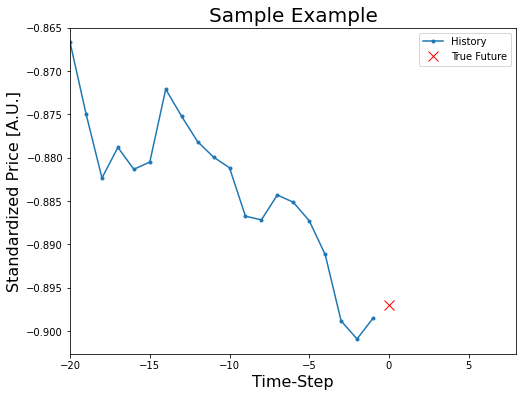

In [ ]:
#CHANGE  ITS NAME (see 2d file), add axis label with certain size and set title size up
def create_time_steps(length):
  return list(range(-length,0))

def plot_short_pred(plot_data, delta, title):
  #This function plots 3 things: History, true future and prediction
  '''
      plot_data (list): [x,y,z]: data to plot in function of time (time_steps).
      delta: (0 = False & 1 = True) I think related with 'univariate_future_target' 
      title (str): plot title.
  '''
  #print(type(plot_data))
  #print(plot_data[0])
  #print(plot_data[0].flatten())
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  #print(plot_data[0].shape[0])
  #print(plot_data[0].shape)
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title, size=20)
  
  for i,x in enumerate(plot_data): #enumerate(plot_data) = (0,x_train),(1,y_train)
    #Note: i = 0 is false, the rest (i.e. i=300) is true
    if i: #(i = 1)
      plt.plot(future, plot_data[i], marker[i],markersize=10, label=labels[i]) #Plotting true future
    else: #(i=0)
      plt.plot(time_steps,plot_data[i].flatten(),marker[i], label=labels[i]) #Plotting History
    plt.legend()
    plt.xlim([time_steps[0], (future+4)*2])
    plt.xlabel('Time-Step', size=16)
    plt.ylabel("Standardized Price [A.U.]", size=16)

  return plt

#Testing function
plot_short_pred([x_train_single_uni[0], y_train_single_uni[0]], 0, 'Sample Example')

In [ ]:
#understanding create_time_steps
#print(list(range(-10,0)))
#---- Enumerate
a = [[[1,2,3,4,5]],[[10]],[[20,30,40]]]
print(a)
#print(type(a))
#print(a[0].flatten()) #error, because a[0] is not a column
#print(enumerate(a))
#enumerate is like a vector of couples like: (index, data)
for i,x in enumerate(a):
  print(i)
  print(x)
  print("end")
#----- numbers, boolean, conditional values and if
print(1==True)
print(0==False)
print(2==False)
if 3:
  print("a")

[[[1, 2, 3, 4, 5]], [[10]], [[20, 30, 40]]]
0
[[1, 2, 3, 4, 5]]
end
1
[[10]]
end
2
[[20, 30, 40]]
end
True
True
False
a


## Función que gráfica la perdida en los datos de entrenamiento y validación

In [ ]:
def plot_loss(history, title):
  #print(history.history)
  loss = history.history['loss']
  #print(loss)
  val_loss = history.history['val_loss']
  #print(val_loss)

  epochs = range(len(loss))
  #print(epochs)

  #1st y axis (training loss)
  fig, ax1 = plt.subplots()
  col1 = "red"
  ax1.set_xlabel("Epoch", size=15)
  ax1.set_ylabel("Training Loss", color=col1, size=20)
  ax1.plot(epochs,loss, color=col1, marker = 'o')
  ax1.tick_params(axis='y', labelcolor=col1)

  #2nd y axis (val loss)
  ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
  col2 = "blue"
  ax2.set_ylabel("Val. Loss", color=col2, size=20)
  ax2.plot(epochs, val_loss, color=col2, marker = "o")
  ax2.tick_params(axis='y', labelcolor=col2)
  plt.title(title, size=19)
  #fig.tight_layout()
  plt.show()

<a name="modelFunct"></a>
# Función(es) de creación del modelo RNN-LSTM
- Es un modelo con una capa intermedia.
- El modelo tiene como un argumento el número de neuronas de la capa intermedia.
- *Candidata a exportar*.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def my_model(n_of_neurons, in_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=n_of_neurons, input_shape=in_shape))
  model.add(tf.keras.layers.Dense(1))
  return model

<a name="1stModels"></a>
#PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.
- Para c/modelo se obtiene la gráfica de perdida para el entrenamiento y la validación.

Para el modelo de 8 neuronas se mostró:
- Resumen (summary) del modelo de 8 neuronas.
- Gráfica de compración de los datos versus predicción corta.

Volver a [Tabla de contenidos](#contents).


### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 8 neuronas en su capa intermedia

In [ ]:
#in_shape=x_train_single_uni.shape[-2:]
%%time
single_step_1D_model = my_model(n_of_neurons=8, in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#training
#To Stop training when a monitored metric has stopped improving.
#Patience: Number of epochs with no improvement after which training will be stopped.
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)

single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=50)
#what steps_per_epoch mean?, what callbacks?, whats validation_step ?

#saving predictions (8 neurons)
predictions8U = single_step_1D_model.predict(x_val_single_uni)

Epoch 1/100
200/200 [==============================] - 9s 6ms/step - loss: 0.3029 - val_loss: 4.1480
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0772 - val_loss: 3.7505
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0523 - val_loss: 3.4654
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0463 - val_loss: 3.2549
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0431 - val_loss: 3.0695
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0405 - val_loss: 2.9726
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0384 - val_loss: 2.9052
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0367 - val_loss: 2.8561
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0356 - val_loss: 2.8173
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0347 - val_lo

In [ ]:
print("--------- Parameters for 8 neurons model ---------")
print(single_step_1D_model.summary())
#This is to understand the number of params
#print(320/8)
#print(x_train_single_uni.shape[-2:])
#single_step_1D_model = my_model(n_of_neurons=16, in_shape=x_train_single_uni.shape[-2:])
#single_step_1D_model.compile(optimizer='adam', loss='mae')
#print(single_step_1D_model.summary())
#print(1152/16)

--------- Parameters for 8 neurons model ---------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(single_step_1D_model_history.history['loss'])
#single_step_1D.history.history

[0.3489745259284973, 0.0964616909623146, 0.07418343424797058, 0.06463509798049927, 0.058282747864723206, 0.05461755767464638, 0.05257461965084076, 0.05116093158721924, 0.05018441751599312, 0.04965312406420708, 0.04919809848070145, 0.04891252517700195, 0.048690248280763626, 0.048465874046087265, 0.04846302047371864, 0.048350997269153595, 0.04823753982782364, 0.04813843220472336, 0.04805613309144974, 0.04829820990562439, 0.048048656433820724, 0.04795398563146591, 0.04800897836685181, 0.047763265669345856, 0.047837648540735245, 0.04774798825383186, 0.04765057936310768, 0.047670427709817886, 0.04772907868027687, 0.04762404039502144, 0.047500159591436386, 0.04765516147017479, 0.04751081392168999, 0.04759000241756439, 0.04738340899348259, 0.04745016619563103, 0.04730279743671417, 0.04752323776483536, 0.04736172407865524, 0.04735783487558365, 0.04731203243136406, 0.0473097562789917, 0.04732930287718773, 0.047320831567049026, 0.047270819544792175, 0.04724656045436859, 0.04717181995511055, 0.04

### Gráfica de la pérdida en función de las epochs

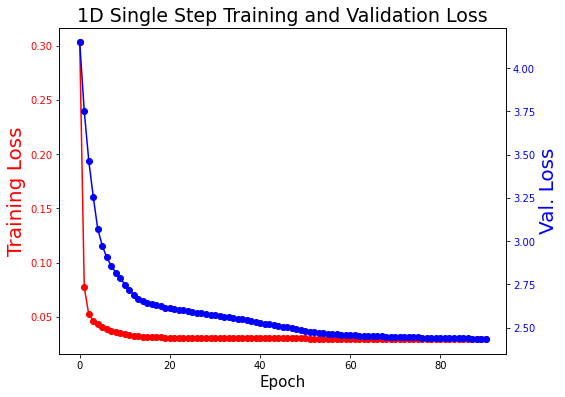

In [ ]:
plot_loss(history=single_step_1D_model_history, title='1D Single Step Training and Validation Loss')
del single_step_1D_model_history

In [ ]:
#Checking prediction shape
for x,y in val_single_uni.take(1):
  print(single_step_1D_model.predict(x).shape)
  #print(simple_lstm_model.predict(x))

(256, 1)


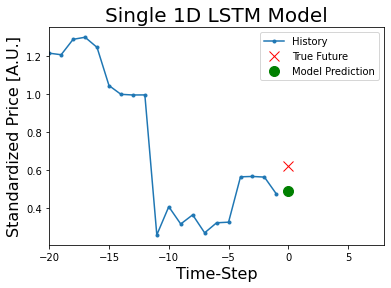

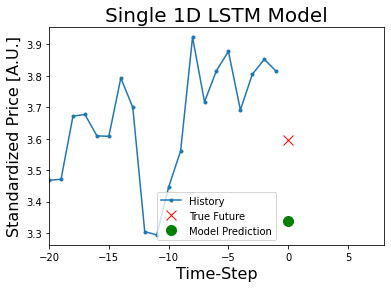

In [ ]:
#print(val_univariate.take(1))
#val_univariate.take(k) is like a vector of k first components containing (x_val,y_val) 
for x,y in val_single_uni.take(2):
  plot = plot_short_pred(plot_data=[x[0].numpy(),y[0].numpy(),single_step_1D_model.predict(x)[0]], delta=0, title='Single 1D LSTM Model')
  plot.show()

In [ ]:
#deleting model
del single_step_1D_model

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 128 neuronas en su capa intermedia (en forma sucinta).

In [ ]:
%%time
tf.keras.backend.clear_session()
single_step_1D_model = my_model(n_of_neurons=128,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#training
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=50)

#saving predictions (128 neurons)
predictions128U = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model

Epoch 1/100
200/200 [==============================] - 3s 7ms/step - loss: 0.0770 - val_loss: 1.5647
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0441 - val_loss: 1.3510
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0368 - val_loss: 1.2705
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0358 - val_loss: 1.2045
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0333 - val_loss: 1.1504
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0324 - val_loss: 1.1280
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0325 - val_loss: 1.1042
Epoch 8/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0321 - val_loss: 1.0986
Epoch 9/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 1.1029
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0314 - val_lo

### Gráfica de la pérdida en función de las epochs

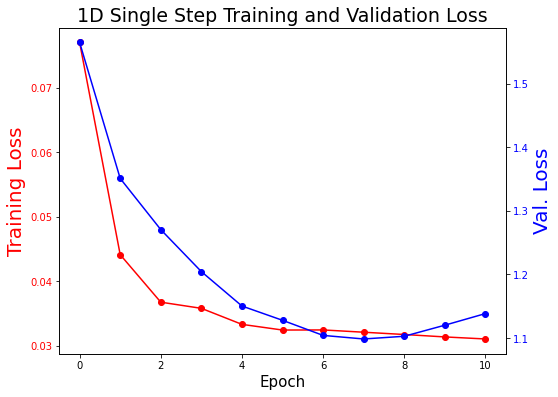

In [ ]:
plot_loss(single_step_1D_model_history, '1D Single Step Training and Validation Loss')
del single_step_1D_model_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 256 neuronas en su capa intermedia.

In [ ]:
%%time
tf.keras.backend.clear_session()
single_step_1D_model = my_model(n_of_neurons=256,in_shape=x_train_single_uni.shape[-2:])
#single_step_1D_model = my_model_2layers(n_of_neurons=256,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#Training
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=50)

#saving predictions (256 neurons)
predictions256U = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model

Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.0713 - val_loss: 1.0480
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0432 - val_loss: 0.8811
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0376 - val_loss: 0.7538
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0339 - val_loss: 0.7476
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0333 - val_loss: 0.9130
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0325 - val_loss: 0.9385
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0316 - val_loss: 0.9364
CPU times: user 11.9 s, sys: 702 ms, total: 12.6 s
Wall time: 12.2 s


### Gráfica de la pérdida en función de las epochs

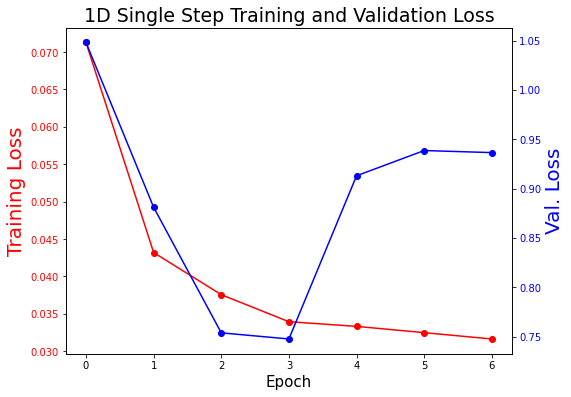

In [ ]:
plot_loss(history=single_step_1D_model_history, title='1D Single Step Training and Validation Loss')
del single_step_1D_model_history

<a name="1stPredPlots"></a>
# Primeras gráficas: Graficando predicciones (8, 128 y 256 neuronas) y mostrando errores (MSE)
- Gráficas de las predicciones de los modelos hechos anteriormente.

Volver a [Tabla de contenidos](#contents).

### Configurando dataframes para obtener series de tiempo (y no solo arrays):

In [ ]:
##To plot train and validation data together with models predictions

#------- Creating dframes (to work with time series) with standirized data
#dframes lengths
N = len(df_btc)
M = len(predictions8U)

#data dataframe
data_std = pd.DataFrame(index=df_btc.index,columns=['AdjCloStd']) #standarized #try to change index to date since this line
train = data_std[:TRAIN_SPLIT]
valid = data_std[TRAIN_SPLIT:]

#predictions dataframe
predictions = pd.DataFrame(index=df_btc.tail(M).index,columns=['Pred8U', 'Pred128U', 'Pred256U'])#try to change index to date since this line

#Filling data dataframe
for i in range(0,N):
  data_std['AdjCloStd'][i] = uni_data[i]

#Filling predictions dataframe
predictions['Pred8U'] = predictions8U
predictions['Pred128U'] = predictions128U
predictions['Pred256U'] = predictions256U

### Graficando serie de tiempo y predicciones:

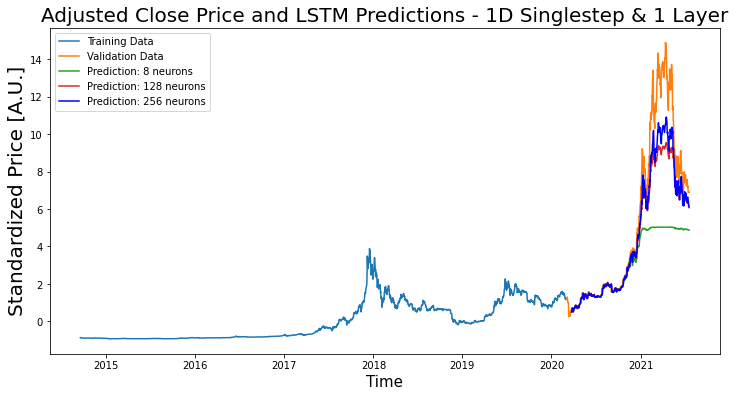

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['AdjCloStd'], label="Training Data")
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="Prediction: 8 neurons")
plt.plot(predictions['Pred128U'], label="Prediction: 128 neurons")
plt.plot(predictions['Pred256U'], label="Prediction: 256 neurons", color='blue')
plt.title("Adjusted Close Price and LSTM Predictions - 1D Singlestep & 1 Layer", size=20)
plt.ylabel("Standardized Price [A.U.]", size=20)
plt.xlabel("Time", size=15)
plt.legend()
plt.show()

### Graficando datos de validación y predicciones

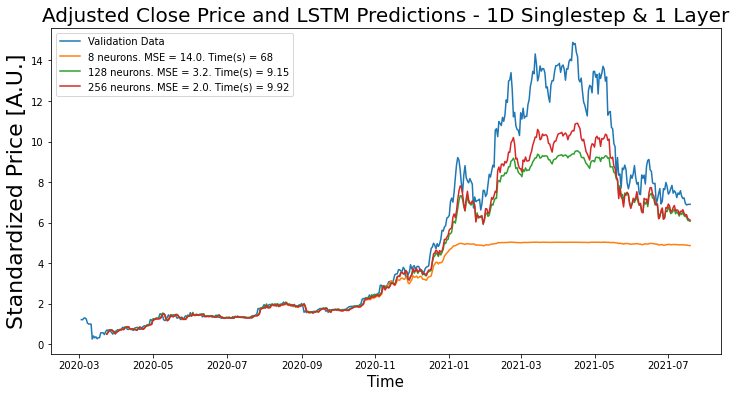

In [ ]:
#training time
T_8U = 68
T_128U = 9.15
T_256U = 9.92

#MSE Calculations
MSE_8U = round(mean_squared_error(y_val_single_uni, predictions8U , squared=True),1)
MSE_128U = round(mean_squared_error(y_val_single_uni, predictions128U , squared=True),1)
MSE_256U = round(mean_squared_error(y_val_single_uni, predictions256U , squared=True),1)

#Plotting
plt.figure(figsize=(12,6))
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="8 neurons. MSE = "+str(MSE_8U)+". Time(s) = "+str(T_8U))
plt.plot(predictions['Pred128U'], label="128 neurons. MSE = "+str(MSE_128U)+". Time(s) = "+str(T_128U))
plt.plot(predictions['Pred256U'], label="256 neurons. MSE = "+str(MSE_256U)+". Time(s) = "+str(T_256U))
plt.title("Adjusted Close Price and LSTM Predictions - 1D Singlestep & 1 Layer", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time", size=15)
plt.legend()
plt.show()
#print(y_train_uni.size)
#print(y_val_uni.size)

<a name="sameModels"></a>
# SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 128 y 512 neuronas)
- Se muestran gráficas de predicciones de 6 modelos: 3 con 128 neuronas y 3 con 512.
- Pregunta: Por que con muchas neuronas (desde 512 hacia arriba) el resultado de la predicción cambiaba mucho al correr el modelo varias veces?

Volver a [Tabla de contenidos](#contents).

##Para 128 neuronas:

In [ ]:
%%time
tf.keras.backend.clear_session()
units=128
###################### 1ND MODEL ##################################
#CREATING MODEL
single_step_1D_model = my_model(n_of_neurons=units,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions128U_1 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_1D_model = my_model(n_of_neurons=units,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions128U_2 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_1D_model = my_model(n_of_neurons=units,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions128U_3 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.0824 - val_loss: 1.5769
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0440 - val_loss: 1.4255
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0373 - val_loss: 1.2726
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0343 - val_loss: 1.1708
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0335 - val_loss: 1.1365
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0317 - val_loss: 1.1217
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0315 - val_loss: 1.1346
Epoch 8/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0313 - val_loss: 1.1497
Epoch 9/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0313 - val_loss: 1.1536
Epoch 1/100
200/200 [==============================] - 4s 9ms/step - loss: 0.0795 - val_los

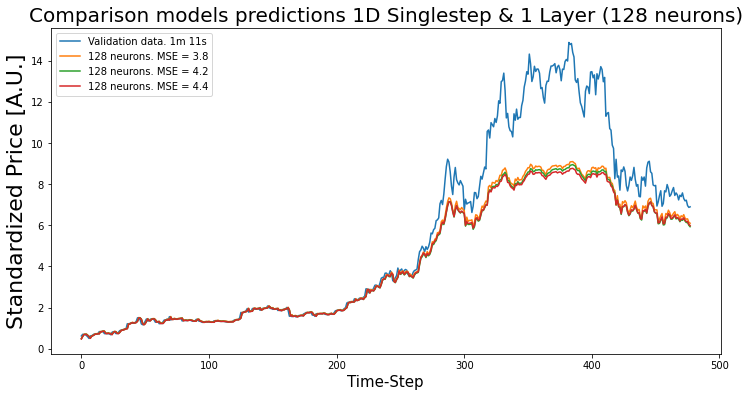

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_128U_1 = round(mean_squared_error(y_val_single_uni, predictions128U_1 , squared=True),1)
MSE_128U_2 = round(mean_squared_error(y_val_single_uni, predictions128U_2 , squared=True),1)
MSE_128U_3 = round(mean_squared_error(y_val_single_uni, predictions128U_3 , squared=True),1) 

#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_single_uni, label="Validation data. 1m 11s")
plt.plot(predictions128U_1, label="128 neurons. MSE = "+str(MSE_128U_1))
plt.plot(predictions128U_2, label="128 neurons. MSE = "+str(MSE_128U_2))
plt.plot(predictions128U_3, label="128 neurons. MSE = "+str(MSE_128U_3))
plt.title("Comparison models predictions 1D Singlestep & 1 Layer (128 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.legend()
plt.show()

#Para 512 neuronas (problemático):


In [ ]:
%%time
###################### 1ND MODEL ##################################
#CREATING MODEL
#tf.keras.backend.clear_session()
single_step_1D_model = my_model(n_of_neurons=512,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions512U_1 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

###################### 2ND MODEL ##################################
#CREATING MODEL
#tf.keras.backend.clear_session()
single_step_1D_model = my_model(n_of_neurons=512,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions512U_2 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

###################### 3RD MODEL ##################################
#CREATING MODEL
#tf.keras.backend.clear_session()
single_step_1D_model = my_model(n_of_neurons=512,in_shape=x_train_single_uni.shape[-2:])
single_step_1D_model.compile(optimizer='adam', loss='mae')

#TRAINING
P = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=EVALUATION_INTERVAL,
                                                    validation_data=val_single_uni,
                                                    callbacks=[early_stopping],
                                                    validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions512U_3 = single_step_1D_model.predict(x_val_single_uni)

#deleting model
del single_step_1D_model, single_step_1D_model_history

Epoch 1/100
200/200 [==============================] - 6s 19ms/step - loss: 0.0734 - val_loss: 0.8394
Epoch 2/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0430 - val_loss: 0.5635
Epoch 3/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0372 - val_loss: 0.5498
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0368 - val_loss: 0.4834
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0349 - val_loss: 0.4815
Epoch 6/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0346 - val_loss: 0.5294
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0332 - val_loss: 0.6189
Epoch 8/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0325 - val_loss: 0.5229
Epoch 1/100
200/200 [==============================] - 5s 20ms/step - loss: 0.0745 - val_loss: 0.7835
Epoch 2/100
200/200 [==============================] - 4s 18ms/step - loss: 0.0444

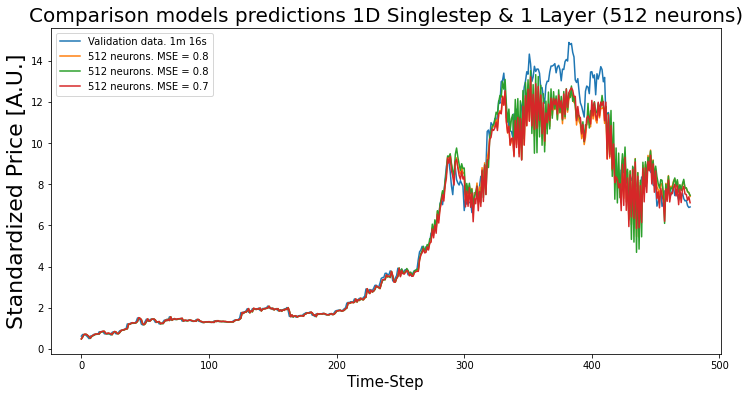

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_512U_1 = round(mean_squared_error(y_val_single_uni, predictions512U_1 , squared=True),1)
MSE_512U_2 = round(mean_squared_error(y_val_single_uni, predictions512U_2 , squared=True),1)
MSE_512U_3 = round(mean_squared_error(y_val_single_uni, predictions512U_3 , squared=True),1) 

#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_single_uni, label="Validation data. 1m 16s")
plt.plot(predictions512U_1, label="512 neurons. MSE = "+str(MSE_512U_1))
plt.plot(predictions512U_2, label="512 neurons. MSE = "+str(MSE_512U_2))
plt.plot(predictions512U_3, label="512 neurons. MSE = "+str(MSE_512U_3))
plt.title("Comparison models predictions 1D Singlestep & 1 Layer (512 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.legend()
plt.show()

<a name="Errors"></a>

#Caracterizando el error (MSE) con modelos de 256 neuronas
- Se hicieron 100 número de simulaciones y se guardó el valor del MSE de cada simulación (en la variable errors).
- Histograma de los errores.
- Pruebas de normalidad.
- Bootstap (intervalo de confianza).

Volver a [Tabla de contenidos](#contents).

In [ ]:
%%time
N_SIM = 100
errors = []
for i in range(N_SIM):
  print("Simulation:"+str(i))
  tf.keras.backend.clear_session()
  single_step_1D_model = my_model(n_of_neurons=256,in_shape=x_train_single_uni.shape[-2:])
  single_step_1D_model.compile(optimizer='adam', loss='mae')

  #Training
  P = 3
  early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
  single_step_1D_model_history = single_step_1D_model.fit(train_single_uni,
                                                      epochs=EPOCHS,
                                                      steps_per_epoch=EVALUATION_INTERVAL,
                                                      validation_data=val_single_uni,
                                                      callbacks=[early_stopping],
                                                      validation_steps=EVALUATION_INTERVAL)

  #saving predictions (256 neurons)
  predictions256U = single_step_1D_model.predict(x_val_single_uni)
  
  #Calculating and saving errors
  MSE = round(mean_squared_error(y_val_single_uni, predictions256U , squared=True),2)
  errors.append(MSE)

  #deleting model
  del single_step_1D_model, single_step_1D_model_history

print(errors)

Simulation:0
Epoch 1/100
200/200 [==============================] - 4s 12ms/step - loss: 0.0757 - val_loss: 0.9857
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0409 - val_loss: 0.9765
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0381 - val_loss: 0.9144
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0339 - val_loss: 0.8322
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0325 - val_loss: 0.8718
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0325 - val_loss: 0.9834
Epoch 7/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0318 - val_loss: 0.9893
Simulation:1
Epoch 1/100
200/200 [==============================] - 4s 12ms/step - loss: 0.0698 - val_loss: 1.1522
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0423 - val_loss: 0.8725
Epoch 3/100
200/200 [==============================] - 2s 10ms/

### Histograma de los errores, pruebas de normalidad, bootstap (intervalo de confianza)



---------- Histograma ----------
100


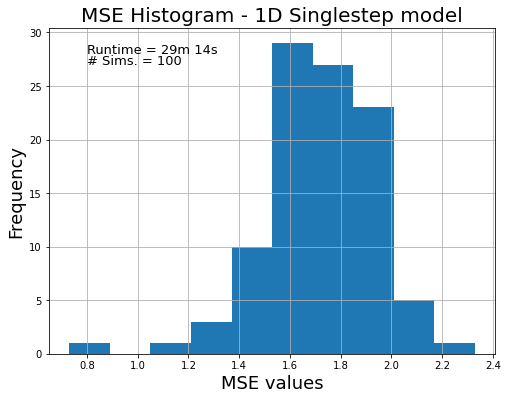

---------- Pruebas de normalidad ----------
Shapiro-Wilk p-value for MSE:  0.0017872066237032413
Kolmogorov-Smirnov p-value for MSE:  2.8061379403186353e-94
---------- Bootstrap ----------
1.7222
[1.6771 1.7669]
0.08979999999999988


In [ ]:
#Errors:
print("---------- Histograma ----------")
xt = 0.8
errors = [1.89, 1.55, 1.9, 1.8, 1.78, 1.31, 1.47, 2.12, 1.82, 1.81, 1.83, 1.99, 1.9, 1.8, 1.68, 1.76, 1.67, 0.73, 1.51, 1.44, 1.71, 1.35, 1.63, 2.33, 1.98, 1.71, 1.85, 1.97, 1.66, 1.64, 1.58, 2.04, 1.65, 1.99, 1.68, 1.62, 1.6, 1.39, 1.61, 1.08, 1.92, 1.41, 1.83, 1.65, 1.9, 1.65, 1.63, 1.89, 1.91, 1.95, 1.59, 1.92, 1.69, 1.84, 1.93, 1.56, 2.0, 2.07, 1.62, 1.68, 1.44, 1.94, 1.8, 1.45, 1.72, 1.58, 1.47, 1.71, 1.74, 1.8, 1.91, 1.57, 1.8, 2.0, 1.75, 1.98, 1.75, 1.89, 1.46, 1.8, 1.57, 1.73, 1.81, 1.83, 1.53, 1.83, 2.01, 1.62, 1.92, 1.61, 1.72, 1.62, 1.44, 1.62, 1.93, 1.78, 1.55, 2.1, 1.33, 1.64]
print(len(errors))
plt.hist(errors)
#plt.title("Histograma de los Errores Cuadráticos Medios de Modelos 1D")
#plt.ylabel("Cuentas")
#plt.xlabel("Valores de MSE")
plt.title("MSE Histogram - 1D Singlestep model", size = 20)
plt.ylabel("Frequency", size = 18)
plt.xlabel("MSE values", size = 18)
plt.text(xt, 28, "Runtime = 29m 14s", size = 13)
plt.text(xt, 27, "# Sims. = 100", size = 13)
plt.grid(True)
plt.show()

print("---------- Pruebas de normalidad ----------")
staB, pvalB = stats.shapiro(errors)
print("Shapiro-Wilk p-value for MSE: ",pvalB)
staB, pvalB = stats.kstest(errors,'norm')
print("Kolmogorov-Smirnov p-value for MSE: ",pvalB)

print("---------- Bootstrap ----------")
random.seed(10)
bs_reps = dcst.draw_bs_reps(errors, np.mean, size = 10000)
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print(np.mean(errors))
#print(np.median(errors256))
print(conf_int)
#print(conf_int-np.mean(errors256))
print(conf_int[1]-conf_int[0])


--------------------

<a name="Conclu"></a>
#Conclusiones e ideas
### Conclusiones:
1. El modelo logra mejores predicciones cuando tiene mas neuronas en su capa intermedia hasta las 256 neuronas.
2. Modelos con 512 neuronas o mas arrojan predicciones muy variables. Es decir distintas predicciones cuando se compilan distintas veces.
3. Los resultados de las predicciones no son 100% repetibles. 
4. El intervalo de confianza (con un nivel de confianza del 95%) para la media del error de la predicción de las series unidimensionales a un paso en un modelo con 256 neuronas en su capa intermedia es 1.7222 +/- (1.677, 1.767) con un $\Delta$Error = 0.089.

### Ideas:
1. Organizar al principio del documento 2 o 3 celdas donde se cargen la funciones y las variables necesarias para trabajar (de datos y de gráficas), y que no haya que cargar tantas celdas para poder correr los modelos.

Volver a [Tabla de contenidos](#contents).





## Bibliografía

### Redes RNN-LSTM (cuaderno).
1. [Introducción a Keras LSTM para series de tiempo multivariadas. Montenegro et.al.](https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnrTimes_series_Multivariate.ipynb).
1. A. [Notebook community: Time series forecasting (Ori. English)](https://notebook.community/tensorflow/docs-l10n/site/en-snapshot/tutorials/structured_data/time_series).
1. B. [Keras Timeseries Multi-Step Multi-Output](https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output).

### Yahoo Finance (datos importados).
2. [Yahoo Finance API – A Complete Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
3. [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/)
4. [yfinance documentation](https://pypi.org/project/yfinance/)

### Cuadernos de referencia.
5. [Predicción de acciones usando análisis multivariado (repo)
](https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis). 
6. [Serie de tiempo multivariadas para predicción de precios en Python](https://www.relataly.com/stock-market-prediction-with-multivariate-time-series-in-python/1815/). 
7. [Conversión de datos (clima)](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/).
8. [Predicción en series de tiempo multivariadas (clima)](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).
### Libro
9. [François Chollet - Deep Learning with Python](https://b-ok.lat/s/Deep%20Learning%20with%20Python%20Fran%C3%A7ois%20Chollet).
### Artículo
10. [Stock Price Prediction Using CONVOLUTIONAL Neural Networks on a Multivariate Timeseries. Article](https://www.researchgate.net/publication/338477393_Stock_Price_Prediction_Using_Convolutional_Neural_Networks_on_a_Multivariate_Timeseries). 
### Número de parametros en una red LSTM
[Número de parametros](https://medium.com/deep-learning-with-keras/lstm-understanding-the-number-of-parameters-c4e087575756).


##Links sobre criptomonedas (bitcoin especialmente)
https://unperiodico.unal.edu.co/pages/detail/criptomonedas-una-herramienta-riesgosa-pero-de-uso-inminente/

https://repositorio.udesa.edu.ar/jspui/bitstream/10908/16022/1/%5BP%5D%5BW%5D%20T.%20M.%20AyPP.%20Lojo%20M%C3%A1rquez%2C%20Tamara%20In%C3%A9s.pdf  (cap2 c, cap3 ii, cap4)

https://www.daviescoin.io/es/blog/que-determina-el-valor-de-las-criptomonedas

https://www.tekcrispy.com/2018/05/16/que-determina-precio-criptomonedas/

https://repositorio.uniagustiniana.edu.co/bitstream/handle/123456789/845/HurtadoCuellar-AngieDaniela-2019.pdf.pdf?sequence=1 (cap7)
